In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import fsolve
import yaml
import control
%load_ext autoreload
%autoreload 2

In [69]:
thrust_init=5.949
elevator_init=-0.2696
aileron_init=0.0
rudder_init=0

x_init = 0
y_init = 0
z_init = -100
phi_init = 0
theta_init = 0.1023
psi_init = 0
u_init = 19.895
v_init = 0
w_init = 2.043
p_init = 0
q_init = 0
r_init = 0

# helix
# way1 = np.array([50*2 ,-14*2,  -100])
# way2 = np.array([86*2,-50*2,  -120])
# way3 = np.array([100*2,-100*2,  -140])
# way4 = np.array([86*2,-150*2,  -160])
# way5 = np.array([50*2,-186*2,  -180])
# way6 = np.array([0*2, -200*2,  -200])
# way7 = np.array([-50*2, -186*2,  -220])
# way8 = np.array([-86*2, -150*2, -240])
# way9 = np.array([-100*2, -100*2, -260])
# way10 = np.array([-86*2, -50*2, -280])
# way11 = np.array([-50*2, -14*2, -300])
# way12 = np.array([-0, -0, -320])
# way1 = np.array([50 ,-14,  -100])
# way2 = np.array([86,-50,  -120])
# way3 = np.array([100,-100,  -140])
# way4 = np.array([86,-150,  -160])
# way5 = np.array([50,-186,  -180])
# way6 = np.array([0, -200,  -200])
# way7 = np.array([-50, -186,  -220])
# way8 = np.array([-86, -150, -240])
# way9 = np.array([-100, -100, -260])
# way10 = np.array([-86, -50, -280])
# way11 = np.array([-50, -14, -300])
# way12 = np.array([-0, -0, -320])


# waypoints = [way1, way2, way3, way4, way5, way6, way7, way8, way9, way10, way11, way12]


# wave
way1 = np.array([100, 100, -100])
way2 = np.array([175, 150, -120])
way3 = np.array([250, 150, -140])
way4 = np.array([325, 100, -110])
way5 = np.array([400, 50, -90])
way6 = np.array([475, 50, -120])
way7 = np.array([550, 100, -150])

# waypoints = [way1, way2, way3, way4, way5, way6, way7]
waypoints = [ way2, way4, way6, way7]

obstacle1 = np.array([60, 40, -100, 5])
obstacles = [obstacle1]


input_init = np.array([[thrust_init], [elevator_init],[aileron_init],[rudder_init]])
state_init = np.array([[x_init], [y_init], [z_init], 
                       [u_init], [v_init], [w_init],
                       [phi_init], [theta_init], [psi_init], 
                       [p_init], [q_init], [r_init]])


In [70]:
with open("aerosonde_parameters.yaml", 'r') as file:
            params = yaml.safe_load(file)

upper_bound_long = np.array([[params['control_limits']['thrust_max']],
                        [params['control_limits']['control_surface_max']]])
lower_bound_long = np.array([[params['control_limits']['thrust_min']],
                        [params['control_limits']['control_surface_min']]])
upper_bound_lat = np.array([[params['control_limits']['control_surface_max']],
                        [params['control_limits']['control_surface_max']]])
lower_bound_lat = np.array([[params['control_limits']['control_surface_min']],
                        [params['control_limits']['control_surface_min']]])

from airplane_3D_util import calculate_Q_R_P
Q_long, Q_lat, R_long, R_lat, P_long, P_lat = calculate_Q_R_P()

MPC_long_param = {
    "Q": Q_long,
    "R": R_long,
    "P": P_long,
    "upper_bound": upper_bound_long,
    "lower_bound": lower_bound_long,
    "mode": "MPC",
    "variables": "long"
}

MPC_lat_param = {
    "Q": Q_lat,
    "R": R_lat,
    "P": P_lat,
    "upper_bound": upper_bound_lat,
    "lower_bound": lower_bound_lat,
    "mode": "MPC",
    "variables": "lat"
}
# print(Q_long)
# print(R_long)
# print(P_long)
# print(Q_lat)
# print(R_lat)
# print(P_lat)


In [71]:
duration = 2.0
dt = 0.05
horizon = 15
from airplane_3D_EOM_RK4 import simulate_airplane_RK4
from airplane_3D_MPC2 import MPC_controller, shift_state, clip_input
from airplane_3D_EOM_Linear import continuous_linearization, continous_to_discrete
current_state = state_init
current_input = input_init
state_list = []
state_list.append(current_state.squeeze())

state_des_list = [[], [], [], [], [], [], [], [], [], [], [], []]
inputs_list = [[], [], [], []]
t_list = []
future_position_list = []
for t in np.arange(0, duration, dt):

    
    
    A_long4, B_long4, A_long6, B_long6, A_lat5, B_lat5, A_lat6, B_lat6 = continuous_linearization(current_state.squeeze(), current_input.squeeze())

    A_long6_discrete, B_long6_discrete = continous_to_discrete(A_long6, B_long6, dt)
    A_lat6_discrete, B_lat6_discrete = continous_to_discrete(A_lat6, B_lat6, dt)

    long_state_shifted, lat_state_shifted, long_u_steady, lat_u_steady, state_des, obstacles_shifted, \
                                is_last_weightpoint = shift_state(current_state.squeeze(), waypoints, obstacles)
    if is_last_weightpoint:
        break
    # if len(waypoints) == 1:
    #     print(current_state)
    #     print(current_input)
    #     raise


    # print(f"long_shifted: {long_state_shifted},\nlat shifted: {lat_state_shifted}")

    # long_x_equilibrium = np.tile(long_state_shifted.T, (horizon,1))
    # lat_x_equilibrium = np.tile(lat_state_shifted.T, (horizon,1))
    # long_u_equilibrium = np.tile(long_u_steady.T, (horizon,1))
    # lat_u_equilibrium = np.tile(lat_u_steady.T, (horizon,1))

    u_des = state_des[3]
    w_des = state_des[5]
    V_mag = np.sqrt(u_des**2 + w_des**2)
    alpha = np.arctan2(w_des, u_des)
    angle = alpha - state_des[7]
    z_mag = np.sin(angle) * V_mag
    xy_mag = np.cos(angle)*V_mag
    psi_des = state_des[8]
    x_mag = np.cos(psi_des) * xy_mag
    y_mag = np.sin(psi_des) * xy_mag

    x_equil = np.arange(0, x_mag*horizon+x_mag/2, x_mag).reshape(-1,1)
    y_equil = np.arange(0, y_mag*horizon+y_mag/2, y_mag).reshape(-1,1)
    z_equil = np.arange(0, z_mag*horizon + z_mag/2, z_mag).reshape(-1,1)
    


    long_current_input, future_long_states = MPC_controller(long_state_shifted, long_u_steady, horizon,
                                        A_long6_discrete, B_long6_discrete, MPC_long_param, obstacles_shifted)
    
    lat_current_input, future_lat_states = MPC_controller(lat_state_shifted, lat_u_steady, horizon,
                                        A_lat6_discrete, B_lat6_discrete, MPC_lat_param, obstacles_shifted)
    
    future_positions = np.hstack((future_long_states.reshape(-1,6)[:,4].reshape(-1,1) + waypoints[0][0]+x_equil,
                                  future_lat_states.reshape(-1,6)[:,5].reshape(-1,1) + waypoints[0][1]+y_equil,
                                  future_long_states.reshape(-1,6)[:,5].reshape(-1,1) + waypoints[0][2]+z_equil))
    future_position_list.append(future_positions)
    print(f"obs:{obstacles_shifted}, pos_in:{[long_state_shifted[4,0], lat_state_shifted[5,0], long_state_shifted[5,0]]}," +\
        f" pos_out:{[future_long_states[4,0], future_lat_states[5,0], future_long_states[5,0]]}")
        #   f" pos_out:{[future_positions[0,0], future_positions[0,1], future_positions[0,2]]}")

    print(future_long_states)
    print(future_lat_states)
    raise
    
    calculated_input = np.vstack((long_current_input, lat_current_input))
    clipped_input = clip_input(calculated_input, current_input, dt)
    # print(f"clipped_input: {clipped_input}")

    t_list.append(t)
    for count, state_des_individual in enumerate(state_des):
        state_des_list[count].append(state_des_individual)
    for count, control_input in enumerate(current_input):
        inputs_list[count].append(control_input)

    # simulate for one time step
    next_state = simulate_airplane_RK4(current_state.squeeze(), clipped_input.squeeze(), dt+dt/2, dt)[1]

    state_list.append(next_state)
    current_state = next_state  
    current_input = clipped_input
     


obs:[array([-115, -110,   20,    5])], pos_in:[-175.0, -150.0, 20.0], pos_out:[-139.81568149802897, -126.96172412582554, 17.505459107102645]
[[-4.04987717e-03]
 [ 3.60585494e-02]
 [-1.81338049e-18]
 [ 1.96178131e-01]
 [-1.39815681e+02]
 [ 1.75054591e+01]
 [ 1.24135010e-01]
 [-1.25657541e-02]
 [-4.59658888e-01]
 [ 1.96178131e-01]
 [-1.10000000e+02]
 [ 1.51967743e+01]
 [ 9.03538932e-02]
 [-5.02475348e-01]
 [-8.12090076e-01]
 [ 1.73195186e-01]
 [-1.09993884e+02]
 [ 1.49993410e+01]
 [ 9.75912829e-02]
 [-1.24324552e+00]
 [-1.01244468e+00]
 [ 1.32590682e-01]
 [-1.09991950e+02]
 [ 1.48006953e+01]
 [ 1.45260491e-01]
 [-2.02641318e+00]
 [-8.34162603e-01]
 [ 8.19684485e-02]
 [-1.09993440e+02]
 [ 1.46057716e+01]
 [ 2.01788973e-01]
 [-2.46364874e+00]
 [-1.57120992e-01]
 [ 4.02603183e-02]
 [-1.09996560e+02]
 [ 1.44222720e+01]
 [ 2.06433235e-01]
 [-2.18702069e+00]
 [ 1.20015184e-01]
 [ 3.24042687e-02]
 [-1.09999101e+02]
 [ 1.42584437e+01]
 [ 1.84209212e-01]
 [-1.70342129e+00]
 [ 1.26030966e-01]
 [ 3

SystemError: <built-in function nlpsol> returned a result with an error set

In [54]:
# done so that state list, t_list, and state_des_list will all have same number of elements
t_list.append(t_list[-1]+dt)
for state_des_individual in state_des_list:
    state_des_individual.append(state_des_individual[-1])
for input_list_individual in inputs_list:
        input_list_individual.append(input_list_individual[-1])
class solutions:
    pass

state_array = np.array(state_list)

sol_rk4 = solutions()
sol_rk4.t = np.array(t_list)
sol_rk4.y = [None] * 12
sol_rk4.y[0] = state_array[:,0]
sol_rk4.y[1] = state_array[:,1]
sol_rk4.y[2] = state_array[:,2]
sol_rk4.y[3] = state_array[:,3]
sol_rk4.y[4] = state_array[:,4]
sol_rk4.y[5] = state_array[:,5]
sol_rk4.y[6] = state_array[:,6]
sol_rk4.y[7] = state_array[:,7]
sol_rk4.y[8] = state_array[:,8]
sol_rk4.y[9] = state_array[:,9]
sol_rk4.y[10] = state_array[:,10]
sol_rk4.y[11] = state_array[:,11]

# wrap all angles between -pi and pi
sol_rk4.y[8] = (sol_rk4.y[8] + np.pi) % (2 * np.pi) - np.pi
np.save("sol_closed.npy", sol_rk4.y)
future_position_array = np.array(future_position_list)
np.save("predicted_path.npy", future_position_array)

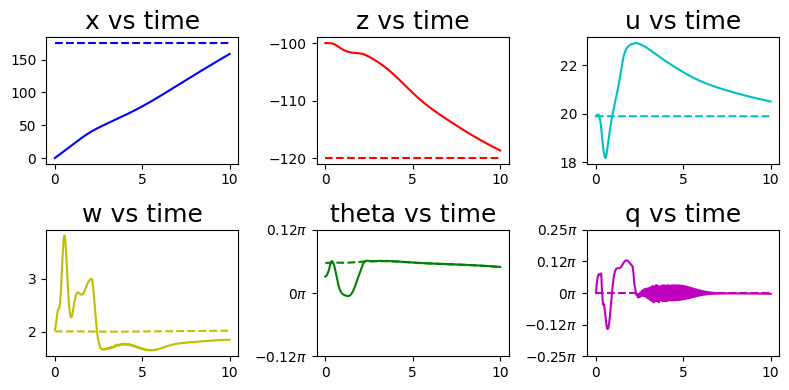

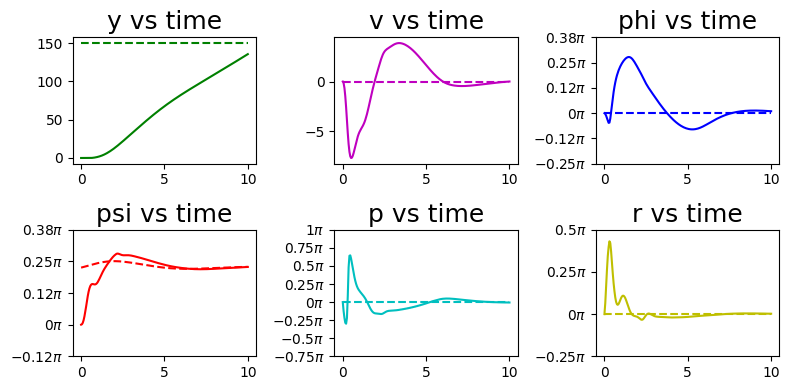

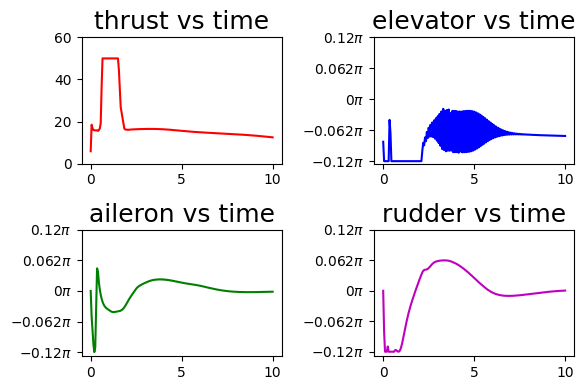

In [55]:
from airplane_plot import plot_airplane_long, plot_airplane_lat, plot_airplane_inputs, plot_wind

plot_airplane_long(sol_rk4, state_des_list, t_list)
plot_airplane_lat(sol_rk4, state_des_list, t_list)
plot_airplane_inputs(inputs_list, t_list)
# plot_wind(x_wind_list, y_wind_list, z_wind_list, np.linspace(0, t_list[-1], len(x_wind_list)))